# Data inspector

## 0. Imports

In [4]:
#To be at project directory root and not in the Notebooks folder
%cd /storage2/mwildi/CBS2

#Imports
import lmdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
import random
from collections import Counter
import cv2
import math
import glob
from image_utils import CoordinateConverter
from matplotlib.patches import Circle

/storage2/mwildi/CBS2


## 1. Read dataset

In [5]:
dataset_path = "dataset/test/main"
repetitions = [x[0] for x in os.walk(dataset_path)][1:]
print('Found {} repetitions'.format(len(repetitions)))
print(repetitions)

Found 8 repetitions
['dataset/test/main/iwryielbvq', 'dataset/test/main/iromohiqsx', 'dataset/test/main/heeykoyifo', 'dataset/test/main/dfbnptewnh', 'dataset/test/main/xtzvkmvnks', 'dataset/test/main/ydujqehbic', 'dataset/test/main/egkvirxwdu', 'dataset/test/main/tkynicdevb']


### 1.1 Decode dataset

In [6]:
def decode_dataset(path):
    lmdb_env = lmdb.open(path)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()

    out = dict()
    for key, value in tqdm(lmdb_cursor):
        out[key.decode("utf-8")] = value

    lmdb_cursor.close()
    return out

def decode_step_data(step_data, kind):
    if kind == 'tls' or kind == 'lbl':
        return np.frombuffer(step_data, dtype=np.uint8)
    
    elif kind.find('wide_rgb') != -1:
        img = np.frombuffer(step_data, dtype=np.uint8)
        img = img.reshape((240, 480, -1))
        return img
    elif kind.find('narr_rgb') != -1:
        img = np.frombuffer(step_data, dtype=np.uint8)
        img = img.reshape((240, 384, -1))
        return img
    elif kind.find('wide_sem') != -1:
        img = np.frombuffer(step_data, dtype=np.uint8)
        img = img.reshape((240, 480))
        return img
    else:
        return np.frombuffer(step_data, dtype=np.float32)
    
data_dict_base = {'lbl':None, 'loc':None, 'rot': None, 'spd':None, 'cmd':None, 'wide_rgb_0':None, 'narr_rgb_0':None, 'tls':None, 'wide_sem_0':None, 'ego_location':None, 'ego_rotation':None, 'cam_location':None, 'cam_rotation':None}      
def decode_step(dataset, step):
    data = data_dict_base
    for t in data.keys():
        d = dataset["{}_{:05d}".format(t, step)]
        data[t] = decode_step_data(d, kind=t)
    return data

In [8]:
rep = decode_dataset(repetitions[4])
total_frames = math.floor(len(rep)/(len(data_dict_base.keys())+2))
print(f'{total_frames} frames found')

5069it [00:00, 40354.65it/s]

337 frames found


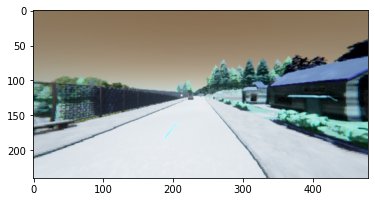

In [9]:
step_data = decode_step(dataset=rep, step=2)
plt.imshow(step_data['wide_rgb_0'])

## 2. Waypoints computation

### 2.1 Tools for transformations

In [10]:
class Location():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __repr__(self,):
        return self.__str__()

    def __str__(self,):
        return "Location(x={}, y={}, z={})".format(self.x, self.y, self.z)

class Rotation():
    def __init__(self, p, y, r):
        self.pitch = p
        self.yaw = y
        self.roll = r

    def __repr__(self,):
        return self.__str__()

    def __str__(self):
        return "Rotation(pitch={}, yaw={}, roll={})".format(self.pitch, self.yaw, self.roll)

class Transform():
    def __init__(self, loc, rot):
        self.location = loc
        self.rotation = rot

    def __repr__(self,):
        return self.__str__()

    def __str__(self,):
        return "Transform({}, {})".format(self.location, self.rotation)

### 2.2 Compute waypoints

In [11]:
def project_vehicle(x, y, z, ori_x, ori_y, ori_z, converter):
    pos = np.array([x,y,z])
    ori = np.array([ori_x, ori_y, ori_z])
    ori /= np.linalg.norm(ori)  # Make unit vector
    new_pos = pos + 4 * ori
    return converter.convert(np.array([new_pos]))

def interpolate_waypoints(points):
    points = points[:, :2]

    # Fit cubic function through points
    z = np.polyfit(points[:, 0], points[:, 1], 2)
    p = np.poly1d(z)

    # Keep interpolating until we have 5 points
    while points.shape[0] < 5:
        points_2 = np.vstack([points[0], points[:-1]])
        max_id = np.argmax(np.linalg.norm(points-points_2, axis=1))
        _x = np.mean([points[max_id], points_2[max_id]], axis=0)[0]
        points = np.insert(points, max_id, np.array([_x, p(_x)]), 0)

    return points

def get_waypoints(REF_FRAME, world_x, world_y, world_z, ori_x, ori_y, ori_z, converter, GAP=5, N_STEP=5):
    if decode_step(rep, REF_FRAME)['tls']:
        vehicle_proj = project_vehicle(world_x, world_y, world_z, ori_x, ori_y, ori_z, converter)
        #output = np.array([vehicle_proj[0] for _ in range(N_STEP)])
        output = np.array([[0, 0] for _ in range(N_STEP)])
        return output

    output = []
    for i in range(REF_FRAME, (REF_FRAME + (N_STEP-1)*GAP), GAP):
        if len(output) == N_STEP:
            break

        pos = decode_step(rep, i)['ego_location']
        image_coords = converter.convert(np.array([[pos[0], pos[1], pos[2]]]))
        if len(image_coords) > 0:
            output.append(image_coords[0])

    if len(output) < 2:
        # First try with smaller GAP
        if GAP == 5:
            return get_waypoints(REF_FRAME, world_x, world_y, world_z, ori_x, ori_y, ori_z, converter, GAP=1)

        vehicle_proj = project_vehicle(world_x, world_y, world_z, ori_x, ori_y, ori_z, converter)
        #print(vehicle_proj.shape)
        #if vehicle_proj.shape[0] > 0:
          #  output = np.array([vehicle_proj[0] for _ in range(N_STEP)])
        #else:
        output = np.array([[0, 0] for _ in range(N_STEP)])
        return output

    if len(output) >= 2 and len(output) < 5:
        return interpolate_waypoints(np.array(output))

    return np.array(output)

In [12]:
PIXELS_PER_METER = 4
PIXELS_AHEAD_VEHICLE = 80

BACKGROUND = [238, 238, 236]

COLORS = [
        (102, 102, 102),
        (253, 253, 17),
        (255, 64, 64),
        (204, 6, 5),
        (0, 0, 142),
        (220, 20, 60),
        (255,0,0),
        (0,255,0),
        (0,0,0),
        (255,255,255),
        (0,255,128),
        (0,128,255),
        ]

SEM_COLORS = {
    4 : (220, 20, 60),
    5 : (153, 153, 153),
    6 : (157, 234, 50),
    7 : (128, 64, 128),
    8 : (244, 35, 232),
    10: (0, 0, 142),
    18: (220, 220, 0),
}

def viz_bv(birdview, no_show=[], num_channels=10):
    h, w = birdview.shape[:2]
    canvas = np.zeros((h, w, 3), dtype=np.uint8)
    canvas[...] = BACKGROUND

    for i in range(num_channels):
        if i in no_show:
            continue
        canvas[birdview[:,:,i] > 0] = COLORS[i]

    return canvas

def viz_sem(sem, labels=[4,6,7,10,18]):
    canvas = np.zeros(sem.shape+(3,), dtype=np.uint8)
    for label in labels:
        canvas[sem==label] = SEM_COLORS[label]
    return canvas

In [13]:
%%capture
import subprocess
import ffmpeg
def generate_video():
    %cd /storage2/mwildi/CBS2
    folder='Notebooks/frames'
    for i in range(10):
        step_data = decode_step(dataset=rep, step=i)
        rgb=step_data['wide_rgb_0']
        bv0=step_data['lbl'].reshape(96,96,-1)
        f, axarr = plt.subplots(1,2, figsize=(15,15))
        axarr[0].imshow(viz_bv(bv0), origin='lower')
        axarr[1].imshow(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
        plt.savefig(folder + "/file%02d.png" % i)
        
    os.chdir(folder)
    
    img_array=[]
    for filename in glob.glob('/storage2/mwildi/CBS2/' + folder + '/*.png'):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 6, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    
    for file_name in glob.glob("*.png"):
        os.remove(file_name)
#generate_video()      

In [14]:
def plot_results(ref_frame_id, locations):
    print(locations)
    plt.figure(figsize=(15,8))
    plt.title("REF FRAME ({}) WITH PROJECTIONS".format(ref_frame_id))
    step = decode_step(rep, ref_frame_id)
    step2 = decode_step(rep, ref_frame_id+100)
    print(step['ego_location'])
    print(step2['ego_location'])
    sem= viz_sem(step['wide_sem_0'])
    print(sem.shape)
    plt.imshow(sem)
    for i, location in enumerate(locations[0]):
        print(i)
        plt.scatter(480/2, 240/2, label="projection {}".format(i), s=100)
        plt.scatter(480/2+location[0], location[0], label="projection {}".format(i), s=10*i+1)
    plt.show()

In [15]:
#REF_FRAME = 2
#plot_results(REF_FRAME, [all_wp[REF_FRAME]])

In [16]:
# %%capture
# from matplotlib.patches import Circle
# # Param
# MAP_SIZE = 96
# REF_FRAME = 10
# N_STEP = 50
# GAP = 2
# N_DATASET_CATEGORIES = 20
# PIXELS_PER_METER = 4

# # Waypoints driver perspective
# from image_utils import CoordinateConverter
# np.set_printoptions(suppress=True)

# cam_x = 1.5
# cam_y = 0
# cam_z = 2.4
# cam_yaw = 0
# cam_roll = 0
# cam_pitch = 0

# N = int((len(rep)-1)/N_DATASET_CATEGORIES -1)
# print(f'Num frames: {N}')

# all_wp = []
# all_dloc = []
# for frame in range((N-1) - N_STEP*GAP + 1):
#         # Extract world coordinates from dataset
#         step_data = decode_step(rep, frame)
#         pos = step_data['ego_location']
#         rot = step_data['ego_rotation']
        
#         # Waypoints driver perspective
#         sensor_transform = Transform(Location(cam_x, cam_y, cam_z), Rotation(cam_yaw, cam_roll, cam_pitch))
#         converter = CoordinateConverter(sensor_transform, fov=120)
#         image_coord_wp = get_waypoints(frame, pos[0], pos[1], pos[2], rot[0], rot[1], rot[2], GAP, N_STEP)
#         all_wp.append(image_coord_wp[:, :2])

#         # Waypoints birdview
#         locs = []
#         for i in range(frame, (frame + N_STEP * GAP), GAP):
#             loc = decode_step(rep,i)['loc'][:2]
#             locs.append(loc)
#         locs = np.array(locs)
#         #dloc is the position of the next 5 waypoints w.r.t the current position
#         dloc = (locs[:] - locs[0:1])*PIXELS_PER_METER - [0-MAP_SIZE/2,-MAP_SIZE/2]
#         all_dloc.append(dloc)

# folder='/storage2/mwildi/CBS2/Notebooks/frames'
# for ref_frame in range((N-1) - N_STEP*GAP + 1):
#     tgt_rgb_loc = all_wp[ref_frame]
#     tgt_bev_loc = all_dloc[ref_frame]
#     f, [rgb_ax, lbl_ax] = plt.subplots(1,2, figsize=(20,10))
#     step_data = decode_step(dataset=rep, step=ref_frame)
#     rgb=step_data['wide_rgb_0']
#     lbl=step_data['lbl'].reshape(96,96,-1)
#     rgb_ax.imshow(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
#     lbl_ax.imshow(np.rot90(np.rot90(viz_bv(lbl))))
#     for i in range(tgt_rgb_loc.shape[0]):
        
#         #TO BE SURE ---------------------------------------------------------------------------------------------------------------------------------------------------------- <<<<<<<<<<<<<<<<<<<
#         rgb_ax.add_patch(Circle([ tgt_rgb_loc[i,1]*2, tgt_rgb_loc[i,0]/2 ], 4, facecolor=(1,0,0,3/(i+3))))
#         #TO BE SURE ---------------------------------------------------------------------------------------------------------------------------------------------------------- <<<<<<<<<<<<<<<<<<<
        
#         lbl_ax.add_patch(Circle(tgt_bev_loc[i], 1, facecolor=(1,0,0,3/(i+3))))
#     plt.savefig(folder + "/file%02d.png" % ref_frame)
#     plt.close()
# os.chdir(folder)
# img_array=[]
# print('Finished')

In [17]:
import glob, os
def clear_frames():
    folder='/storage2/mwildi/CBS2/Notebooks/frames'
    for file_name in glob.glob(folder+ "/*.png"):
        os.remove(file_name)
    print('Finished')

In [18]:
def loc_frame(rep, frame):
    # Extract world coordinates from dataset as well as rgb image and birdview
    step_data = decode_step(rep, frame)
    rgb=step_data['wide_rgb_0']
    lbl=step_data['lbl'].reshape(96,96,-1)
    pos = step_data['ego_location']
    rot = step_data['ego_rotation']
    cam_pos = step_data['cam_location']
    cam_rot = step_data['cam_rotation']
    print(pos)
    
    # Waypoints driver perspective
    sensor_transform = Transform(Location(cam_pos[0], cam_pos[1], cam_pos[2]), Rotation(cam_rot[0], cam_rot[1], cam_rot[2]))
    converter = CoordinateConverter(sensor_transform, fov=120)
    image_coord_wp = get_waypoints(frame, pos[0], pos[1], pos[2], rot[0], rot[1], rot[2], converter, GAP, N_STEP)

    # Waypoints birdview
    locs = []
    for i in range(frame, (frame + N_STEP * GAP), GAP):
        loc = decode_step(rep,i)['loc'][:2]
        locs.append(loc)
    locs = np.array(locs)
    #dloc is the position of the next 5 waypoints w.r.t the current position
    dloc = (locs[:] - locs[0:1])*PIXELS_PER_METER - [0-MAP_SIZE/2,-MAP_SIZE/2]

    # Store computed waypoints
    tgt_rgb_loc = image_coord_wp[:, :2]
    tgt_bev_loc = dloc
    print(tgt_rgb_loc[0])

    # Plot
    fbev, axbev = plt.subplots(figsize=(10,10))
    axbev.imshow(viz_bv(lbl))
    for i in range(tgt_rgb_loc.shape[0]):   
        axbev.add_patch(Circle(tgt_bev_loc[i], 1, facecolor=(1,0,0,3/(i+3))))
    #axbev.axis('off')
    plt.savefig(folder + "/bev%d.png" % frame)
    plt.close()

    frgb, axrgb = plt.subplots(figsize=(10,10))
    axrgb.imshow(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
    for i in range(tgt_rgb_loc.shape[0]):   
        axrgb.add_patch(Circle([ tgt_rgb_loc[i,1]*2, tgt_rgb_loc[i,0]/2 ], 4, facecolor=(1,0,0,3/(i+3))))
        axrgb.add_patch(Circle([ tgt_rgb_loc[i,0], tgt_rgb_loc[i,1] ], 4, facecolor=(0,1,0,3/(i+3))))
        #axrgb.add_patch(Circle([ 480/2 + tgt_rgb_loc[i,0], 240 - tgt_rgb_loc[i,1] ], 4, facecolor=(1,0,0,3/(i+3))))
    #axrgb.axis('off')
    plt.savefig(folder + "/rgb%d.png" % frame)
    plt.close()
    return np.zeros((2,3)), np.zeros((2,3))

In [19]:
%%capture
# Param
MAP_SIZE = 96
N_STEP = 5
GAP = 5
N_DATASET_CATEGORIES = len(data_dict_base.keys())+2
PIXELS_PER_METER = 4

# Waypoints driver perspective

np.set_printoptions(suppress=True)

# cam_x = 1.5
# cam_y = 0
# cam_z = 2.4
# cam_yaw = 0
# cam_roll = 0
# cam_pitch = 0

N = int((len(rep)-1)/N_DATASET_CATEGORIES -1)
print(f'Num frames: {N}')
folder='/storage2/mwildi/CBS2/Notebooks/frames'

all_wp = []
all_dloc = []
frame_range = range((N-1) - N_STEP*GAP + 1)
START_FRAME = 0
frame_range = range(START_FRAME, (N-1) - N_STEP*GAP + 1)
for frame in frame_range:
    tgt_rgb_loc, tgt_bev_loc = loc_frame(rep,frame)
    all_wp.append(tgt_rgb_loc)
    all_dloc.append(tgt_bev_loc)
print('Finished')


for i in frame_range:
    bev = cv2.imread(f'{folder}/bev{i}.png')
    rgb = cv2.imread(f'{folder}/rgb{i}.png')
    if rgb is not None and bev is not None:
        f, [rgb_ax, lbl_ax] = plt.subplots(1,2, figsize=(20,10))
        rgb_ax.imshow(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
        lbl_ax.imshow(cv2.cvtColor(np.rot90(np.rot90(bev)), cv2.COLOR_RGB2BGR))
        rgb_ax.axis('off')
        lbl_ax.axis('off')
        #plt.savefig(folder + "/mix%d.png" % i)
        plt.show()

In [20]:
#from IPython.display import Video
#Video("Notebooks/frames/project.mp4", embed=True)
#clear_frames()

In [21]:
#os.chdir(folder)
img_array=[]
folder='/storage2/mwildi/CBS2/Notebooks/frames'
for i in frame_range:
    bev = cv2.imread(f'{folder}/bev{i}.png')
    rgb = cv2.imread(f'{folder}/rgb{i}.png')
    if rgb is not None and bev is not None:
        f, [rgb_ax, lbl_ax] = plt.subplots(1,2, figsize=(20,10))
        rgb_ax.imshow(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
        lbl_ax.imshow(cv2.cvtColor(np.rot90(np.rot90(bev)), cv2.COLOR_RGB2BGR))
        rgb_ax.axis('off')
        lbl_ax.axis('off')
        plt.savefig(folder + "/mix%d.png" % i)
        plt.close()

In [22]:
for i in frame_range:
    img = cv2.imread(f'{folder}/mix{i}.png')
    if img is not None:
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
out = cv2.VideoWriter('projeceet.mp4',0x7634706d, 5, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
# import matplotlib
# step = 280
# step_data = decode_step(dataset=rep, step=step)
# lbl=step_data['lbl'].reshape(96,96,-1)
# f, lbl_ax = plt.subplots(figsize=(20,10))
# lbl_ax.imshow(np.rot90(np.rot90(viz_bv(lbl))))
# lbl_ax.add_patch(Circle([ tgt_rgb_loc[i,1]*2, tgt_rgb_loc[i,0]/2 ], 4, facecolor=(1,0,0,3/(i+3))))
# f.savefig(folder + "/aaa.png")
# plt.close()
# img = cv2.imread(f'{folder}/aaa.png')
# plt.imshow(np.rot90(img))

In [ ]:
# import matplotlib
# step = 280
# step_data = decode_step(dataset=rep, step=step)
# lbl=step_data['lbl'].reshape(96,96,-1)
# f, [rgb_ax, lbl_ax] = plt.subplots(1,2, figsize=(20,10))
# lbl_ax.imshow(np.rot90(np.rot90(viz_bv(lbl))))
# tgt_rgb_loc = all_wp[step]
# tgt_bev_loc = all_dloc[step]
# for i in range(tgt_rgb_loc.shape[0]):
#     #TO BE SURE ---------------------------------------------------------------------------------------------------------------------------------------------------------- <<<<<<<<<<<<<<<<<<<
#     rgb_ax.add_patch(Circle([ tgt_rgb_loc[i,1]*2, tgt_rgb_loc[i,0]/2 ], 4, facecolor=(1,0,0,3/(i+3))))
#     #TO BE SURE ---------------------------------------------------------------------------------------------------------------------------------------------------------- <<<<<<<<<<<<<<<<<<<
#     bev_wp_patch = Circle(tgt_bev_loc[i], 1, facecolor=(1,0,0,3/(i+3)))
#     #rot180 = matplotlib.transforms.Affine2D().rotate_deg(180)
#     lbl_ax.add_patch(bev_wp_patch)
#     bev_wp_patch.set_transform(rot180)
#     lbl_ax.add_patch(bev_wp_patch)